# Demolitions
Code for a project on the demolition program in Detroit.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as sci
import seaborn as sns
import statsmodels.api as sm
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Import datasets

#demolitions
demos=gpd.read_file('data/Completed_Residential_Demolitions')

#Tract shapefile
michigan=gpd.read_file('data/Census_Tracts_Census_2010_Michigan')

#Motorcity Mapping Blight Tracker parcel survey summary file
blight=pd.read_csv('data/MotorCityMapping_Blight.csv', dtype={'GEOID10':'str'})

#Import HOLC redline shapefiles for Detroit
redline=gpd.read_file('data/redlin_detroit1939')

#Import the status of each parcel in the city as shapefile - to limit to all abandoned structures
trkrpoints=gpd.read_file('data/Motor_City_Mapping_Winter_201314_Certified_Results')

#Import Hardest Hit Fund Demolition Initial Target Areas
hhf=gpd.read_file('data/Hardest_Hit_Fund_Areas_with_Expansion')

#Import sociodemographic data from NHGIS
nhgis=pd.read_csv('data/nhgis0011_csv/nhgis0011_ds239_20185_2018_tract.csv', dtype={'STATEA' : str, 'COUNTYA' : str, 'TRACTA' : str}, encoding='latin-1')



In [3]:
#align all CRSs to the michigan tract file crs

demos=demos.to_crs(michigan.crs)
redline=redline.to_crs(michigan.crs)
trkrpoints=trkrpoints.to_crs(michigan.crs)
hhf=hhf.to_crs(michigan.crs)

## I. Demolition Data and Connect to Census Tracts

,address,parcel_id,contractor,price,funding_so,demolition,commercial,council_di,neighborho,emergency_,street_num,street_dir,street_nam,street_typ,block_rang,ObjectId,geometry,year
0,14877 Wilfred,21011199.,Salenbien Trucking & Excavating Inc.,20258.4,HHF,2018-04-11T00:00:00.000Z,No,4,Outer Drive-Hayes,No,14877,None,WILFRED,St,14700-14899 Wilfred St,1,POINT (13501100.701 338197.417),2018
1,19960 Mccormick,21080155.,"Adamo Group, Inc.",16019.2,Non-HHF,2019-11-26T00:00:00.000Z,No,4,Moross-Morang,No,19960,None,MCCORMICK,St,19900-20199 McCormick St,2,POINT (13509318.389 341740.358),2019


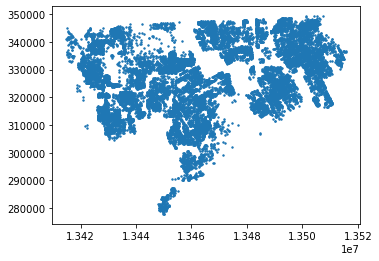

In [4]:
#calculate year
demos['year']=pd.to_datetime(demos['demolition']).apply(lambda x: x.year.astype(int))

#look at it
demos.plot(markersize=2)
demos.head(2)

<AxesSubplot:>

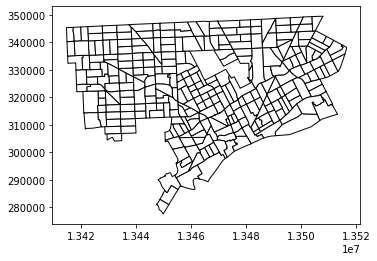

In [5]:
#Limit Michigan data to just Detroit tracts
detroit=michigan[michigan['City'] == 'Detroit'].reset_index(drop=True)
detroit.plot(color='white', edgecolor='black')

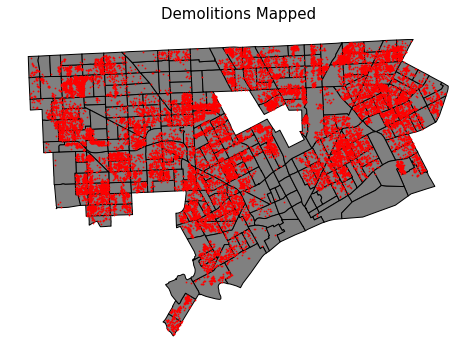

In [6]:
#overlay demolitions and tracts on same map

#tract basemap
base=detroit.plot(color='grey', edgecolor='black', figsize=(9,6))

#Demolition points
demos.plot(ax=base, markersize=.5, marker='o', color='red')

#format
plt.title('Demolitions Mapped', fontdict={'fontsize' : 15})
base.set_axis_off()

<AxesSubplot:>

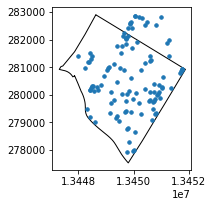

In [7]:
#Peak at one census tract
base=detroit[detroit['OBJECTID'] == 11].plot(color='white', edgecolor='black', figsize=(3,3))
xmin,ymin,xmax,ymax=detroit[detroit['OBJECTID'] == 11].total_bounds
demos.cx[xmin:xmax,ymin:ymax].plot(ax=base, markersize=12)

In [8]:
#Spatial Join together to calculate demolitions per tract
demo_tract=gpd.sjoin(left_df=detroit, right_df=demos, how='left', op='contains')

print(demo_tract.shape)
demo_tract.head(2)

(20483, 36)


,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,...,council_di,neighborho,emergency_,street_num,street_dir,street_nam,street_typ,block_rang,ObjectId,year
0,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,1118325,...,6.0,Boynton,No,3795.0,None,BASSETT,St,3700-3851 S Bassett St,19973.0,2019.0
0,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,1118325,...,6.0,Boynton,No,3787.0,None,BASSETT,St,3700-3851 S Bassett St,19974.0,2015.0


In [9]:
#Calculate demolitions by tract
demolition_by_tract=demo_tract.groupby(['STATEFP10','COUNTYFP10','TRACTCE10'])['OBJECTID'].count().reset_index()

#rename columns
demolition_by_tract.columns = ['statefp','countyfp','tractfp','demolitions']

#generate geoid
demolition_by_tract['tractid']=demolition_by_tract['statefp'] + demolition_by_tract['countyfp'] + demolition_by_tract['tractfp']


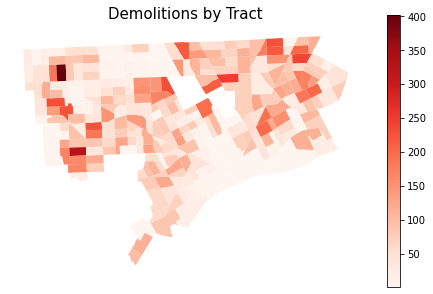

In [10]:
#Chloropleth map of demolitions by tract

#merge number of demolitions by tract to tract shp
gdf_tractdemos=pd.merge(detroit,demolition_by_tract, how='left', left_on='TRACTCE10', right_on='tractfp')

#plot
ax=gdf_tractdemos.plot(column='demolitions', cmap='Reds', 
                       edgecolor=None,
                       legend=True,
                       figsize=(8,10),
                       legend_kwds={'shrink' : .5})

#format and save
plt.title('Demolitions by Tract', fontdict={'fontsize' : 15})
ax.set_axis_off()
plt.gcf().savefig('figures/demosbytract.png',bbox_inches='tight')

## II. Blight by tract data for Detroit
https://portal.datadrivendetroit.org/datasets/census-tracts-census-2010-michigan/data
https://portal.datadrivendetroit.org/datasets/motor-city-mapping-winter-2013-14-certified-results
https://portal.datadrivendetroit.org/datasets/motor-city-mapping-certified-results-winter-2013-14-census-tract-aggregation/data

In 2013, a committee on blight in Detroit worked with a non-profit to survey all parcels in the city and highlight the locations of all abandoned buildings that were suggested for demolitions. This section shows the spatial distribution of abandonment (parcels with no structures and parcels with unoccupied structures) in Detroit and highlights an interesting feature. It also makes the obvious point that places with more unoccupied structures will have more demolition. Then it looks at how the unoccupied structures are spatially distributed.

In [11]:
#Look at blight summary data
print(blight.shape)
blight.head(3)

(297, 108)


,OBJECTID,GEOID10,SqMiles,Acres,Parcel_Count,Total_Surveyed,PctSurveyed,StructureYes,Pct_StructureYes,StructureNo,...,Public_Use_Lots,EmptyLot_PublicUse_ParkGarden,PctLots_ParkGarden,PctPULots_ParkGarden,EmptyLot_PublicUse_ParkingLot,PctLots_ParkingLot,PctPULots_ParkingLot,EmptyLot_PublicUse_Other,PctLots_OtherPublicUse,PctPULots_OtherPU
0,1,26163524800,0.431788,276.344125,1672,1667.0,0.997010,1297.0,0.778044,370.0,...,3.0,NaN,0.000000,0.000000,NaN,0.000000,0.000000,2.0,0.005405,0.666667
1,2,26163521900,0.653458,418.213255,1203,1201.0,0.998337,541.0,0.450458,660.0,...,12.0,7.0,0.010606,0.583333,5.0,0.007576,0.416667,NaN,0.000000,0.000000
2,3,26163521800,0.086837,55.575730,36,36.0,1.000000,26.0,0.722222,10.0,...,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN


In [12]:
#retain only necessary columns
blight_lim=blight[['OBJECTID','GEOID10','ResStruct_Unoccupied','Total_Surveyed','StructureNo']]

#fill na values with 0
blight_lim['ResStruct_Unoccupied']=blight_lim['ResStruct_Unoccupied'].fillna(0)
blight_lim['StructureNo']=blight_lim['StructureNo'].fillna(0)

Text(0.5, 1.0, 'Empty Parcel or Vacant Structure')

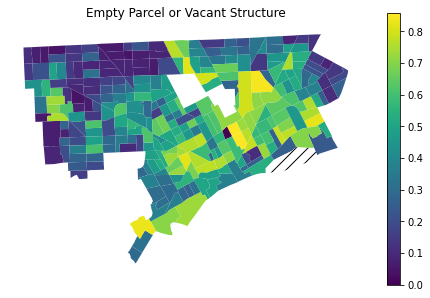

In [13]:
#merge data to tract gdf, calculate vacancy rate, and plot

#merge
blight_gdf=pd.merge(detroit,blight_lim,left_on='GEOID10',right_on='GEOID10',how='left')

#calculate a vacancy rate that is the sum of parcels without a structure and unoccupied structures
blight_gdf['vacant_rate'] = (blight_gdf['StructureNo'] + blight_gdf['ResStruct_Unoccupied'])/blight_gdf['Total_Surveyed']

#plot
ax=blight_gdf.plot(column='vacant_rate',
                   legend=True,figsize=(8,10),
                   legend_kwds={'shrink' : .5}, 
                   missing_kwds={'hatch' : '//', 'color': 'white'})

#format
ax.set_axis_off()
ax.set_title("Empty Parcel or Vacant Structure")

It is interesting that there are areas of really high vacancy right around downtown when normally land near downtown would be more densely populated. Maybe while population was leaving Detroit, people from other neighborhoods didn't want to move closer despite the potential convenience of being closer to downtown.

In [14]:
#Merge abandoned structures by tract to demolitions by tract
tract_demo_blight=pd.merge(demolition_by_tract, blight_lim, how='left', left_on='tractid',right_on='GEOID10')
tract_demo_blight['ResStruct_Unoccupied'] = tract_demo_blight['ResStruct_Unoccupied'].fillna(0)

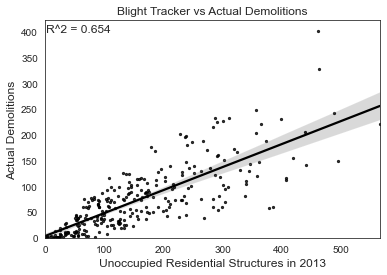

In [15]:
#Scatter plot of demolitions by tract against abandoned residential structures by tract
sns.set_style('white')

#calculate R-Squared
X=tract_demo_blight['ResStruct_Unoccupied']
Y=tract_demo_blight['demolitions']
slope, intercept, r_value, p_value, std_err=sci.linregress(X,Y)
Yhat=intercept + slope*X

#plot and add R2
sns.regplot(X,Y,color='black',scatter_kws={'s' : 5})
plt.text(1,400, 'R^2 = '+str(round(r_value**2,3)), fontsize=12)

#format and save
plt.title('Blight Tracker vs Actual Demolitions', fontsize=12)
plt.xlabel('Unoccupied Residential Structures in 2013', fontsize=12)
plt.ylabel('Actual Demolitions', fontsize=12)
plt.xlim(0,)
plt.ylim(0,)
plt.savefig('figures/abandonedunits.png')

In [16]:
#Examine the spatial location of unoccupied structures
trkrpoints.head(3)

,OBJECTID,D3_SurveyP,CityParcel,AddCombo,Address_Nu,Address_Di,Street,Zip,PCount,Blext_ID,...,Improved,Maintained,PublicUse,Notes,GEOID10_Tr,NAMELSAD10,GEOID10_Bl,NAME10_Blo,GeoID10_BG,geometry
0,1,01000004.001,01000004.001,201 RANDOLPH,201,None,RANDOLPH,48200,1,411094,...,None,None,None,Parcel contains portion of Detroit-Windsor Tunnel,26163517200,Census Tract 5172,261635172001080,Block 1080,261635172001,"POLYGON ((13481800.246 304664.513, 13481447.62..."
1,2,01000004.002L,01000004.002L,159 RANDOLPH,159,None,RANDOLPH,48200,1,411082,...,None,None,None,None,26163517200,Census Tract 5172,261635172001082,Block 1082,261635172001,"POLYGON ((13481909.092 304593.598, 13481507.62..."
2,3,01000005.002L,01000005.002L,160 E JEFFERSON,160,E,JEFFERSON,None,1,411127,...,None,None,None,None,26163517200,Census Tract 5172,261635172001088,Block 1088,261635172001,"POLYGON ((13482027.492 304383.538, 13481674.12..."


In [17]:
#convert parcel polygons to points
trkrpoints['point'] = trkrpoints['geometry'].centroid
trkrpoints=trkrpoints.set_geometry('point')

<AxesSubplot:>

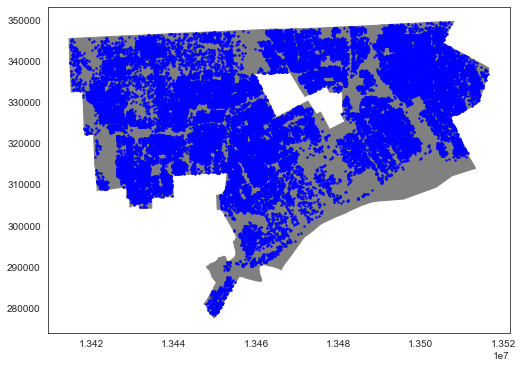

In [18]:
#plot the location of all unoccupied structures in the blight tracker survey

ax1=detroit.plot(color='grey', edgecolor='grey', figsize=(9,6))
trkrpoints[trkrpoints['Occupancy'] == 'unoccupied'].plot(color='blue', markersize=2, ax=ax1)

## III. Detroit Redlining Maps and Blight Data
This tests a hypothesis suggested by Dr. Kim in places that were formerly redlined because they were segregated and suffered disinvestment and will continue to be disproportionately poor today. The graph below only finds modest support for this. Areas with the highest grade have substantially less demolition, but the next three grades all have similar amounts.

In [19]:
#Peak at redline df
redline.head(3)

,name,holc_id,holc_grade,geometry
0,None,A1,A,"POLYGON ((13456243.565 344527.721, 13456277.14..."
1,None,A10,A,"POLYGON ((13516298.648 323632.815, 13515743.24..."
2,None,A11,A,"POLYGON ((13516748.667 334409.261, 13516564.42..."


<AxesSubplot:>

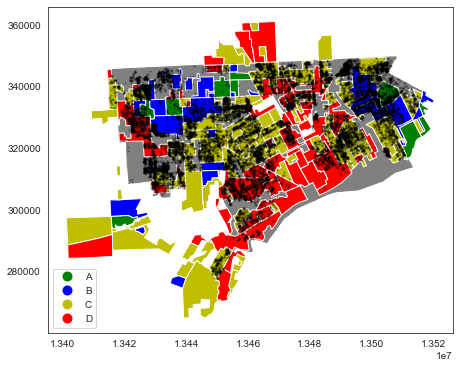

In [20]:
#A terrible looking map

#create cmap with specific colors
cmap=ListedColormap(['g','b','y','r'])

#Get bounds for plot
minx,miny,maxx,maxy=demos.total_bounds

#detroit tracts basemap
base1=detroit.plot(color='gray', edgecolor='gray', figsize=(9,6))

#overlay the redline shapes - limit to the areas within the Detroit bounds
base=redline.cx[minx:maxx,miny:maxy].plot(ax=base1,
                                          column='holc_grade', 
                                          legend=True, 
                                          cmap=cmap, 
                                          legend_kwds={'loc':'lower left'})

#plot the demolitions over the the redline shapes
demos.plot(ax=base1, markersize=2, alpha=.2, color='black')

In [21]:
#demolitions by holc_grade

#spatial join the demolition points to the redlining shapes
red_demo=gpd.sjoin(demos,redline, how='left', op='within')

#summarize demolitions by redline shape
red_demo_summary=red_demo.groupby('holc_grade')['parcel_id'].count().reset_index().rename(columns={'parcel_id': 'demolitions'})
red_demo_summary

,holc_grade,demolitions
0,A,472
1,B,2919
2,C,9610
3,D,4940


In [22]:
#total area of each grade
redline['area'] = redline['geometry'].area
redline_areas=pd.DataFrame(redline.groupby('holc_grade')['area'].sum()).reset_index()

In [23]:
#Demos per million square feet in each grade
demo_area=pd.merge(red_demo_summary,redline_areas, how='inner')
demo_area['demos_per_area'] = demo_area['demolitions']/demo_area['area']*1000000
demo_area.head()

,holc_grade,demolitions,area,demos_per_area
0,A,472,3.612610e+08,1.306535
1,B,2919,8.110285e+08,3.599134
2,C,9610,2.937748e+09,3.271213
3,D,4940,1.634750e+09,3.021869


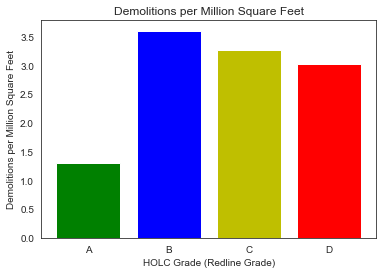

In [24]:
#create bar graph to display data
ax=plt.bar(demo_area.holc_grade,demo_area.demos_per_area, color=['g','b','y','r'])

#format and save
plt.title('Demolitions per Million Square Feet')
plt.xlabel('HOLC Grade (Redline Grade)')
plt.ylabel('Demolitions per Million Square Feet')

plt.gcf().savefig('figures/redline_demo.png', bbox_inches='tight')

## IV. Merge Census data via NHGIS

Connect census data to explore relationships between demographics in a tract and subsequent demolition.

In [25]:
nhgis.head(3)

,GISJOIN,YEAR,STATE,STATEA,COUNTY,COUNTYA,TRACTA,NAME_E,AJWME001,AJWNE001,...,AJ1UM003,AJ14M001,AJ14M002,AJ14M003,AJ14M004,AJ14M005,AJ14M006,AJ14M007,AJ14M008,AJ3QM001
0,G0100010020100,2014-2018,Alabama,1,Autauga County,1,20100,"Census Tract 201, Autauga County, Alabama",1923,1923,...,63,21,12,12,12,12,12,12,21,48508.0
1,G0100010020200,2014-2018,Alabama,1,Autauga County,1,20200,"Census Tract 202, Autauga County, Alabama",2028,2028,...,88,67,37,12,12,22,12,12,63,17304.0
2,G0100010020300,2014-2018,Alabama,1,Autauga County,1,20300,"Census Tract 203, Autauga County, Alabama",3476,3476,...,123,89,12,53,19,12,12,12,65,22197.0


In [26]:
#Calculate relevant statistics

nhgis['pct_black'] = nhgis.AJWVE004/nhgis.AJWVE001*100
nhgis['med_household_inc'] = nhgis.AJZAE001
nhgis['vacancy_rate'] = nhgis.AJ1TE003/nhgis.AJ1TE001*100
nhgis['median_house_value'] = nhgis.AJ3QE001
nhgis['ownershiprate'] = nhgis.AJ1UM002/nhgis.AJ1UM001*100

In [27]:
#limit tracts to Wayne County
nhgis_detroit=nhgis[(nhgis['STATE'] == 'Michigan') & (nhgis['COUNTY'] == 'Wayne County')]

In [28]:
#merge the demographic data with the df containing the number of abandoned structures and the number of demolitions
demo_blight_nhgis=pd.merge(tract_demo_blight, nhgis_detroit, how='left', left_on='tractfp', right_on='TRACTA')

In [29]:
#only retain necessary columns
dem_rate=demo_blight_nhgis[['pct_black', 'med_household_inc',
       'vacancy_rate', 'median_house_value', 'ownershiprate', 'tractfp','demolitions','ResStruct_Unoccupied']]

In [30]:
#merge tract data with the tract gdf
detroit_demo=pd.merge(detroit,dem_rate,how='left',left_on='TRACTCE10',right_on='tractfp')

## V. Analyze Hardest Hit Fund Areas

In [31]:
hhf.head(3)

,OBJECTID,Shape_Leng,Id,Name,Area_Type,geometry
0,1,74732.356575,0,Northwest,Prospective,"POLYGON ((13432941.685 344952.046, 13432977.84..."
1,2,0.000000,0,Warrendale,Prospective,"POLYGON ((13423322.779 322276.329, 13426031.00..."
2,3,0.000000,0,Near East Side,Prospective,"POLYGON ((13492843.081 319949.171, 13490876.80..."


<AxesSubplot:>

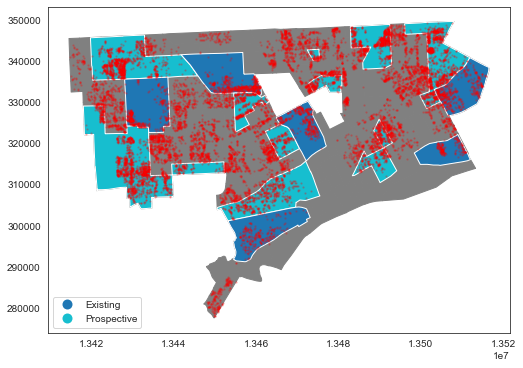

In [32]:
#Map HHF areas and demolitions

#tract basemap
base1=detroit_demo.plot(color='grey', figsize=(9,6), edgecolor='grey')

#hardest hit fund target areas
hhf.plot(column='Area_Type', ax=base1, legend=True)

#demolitions paid for via hardest hit fund grant
demos[demos['funding_so'] == 'HHF'].plot(ax=base1, markersize=2, alpha=.2, color='red')

In [33]:
#identify the tracts within HHF areas

#calculate centroid of each tract and set geometry
detroit_demo['centeroid'] = detroit_demo.centroid
detroit_demo=detroit_demo.set_geometry('centeroid')

#spatial join the tract centroids and the hhf polygons
hhf_tract=gpd.sjoin(detroit_demo,hhf, how='left', op='within')

#change detroit_demo geometry back to the tract polygon
detroit_demo=detroit_demo.set_geometry('geometry')

#peak
hhf_tract.head()


,OBJECTID_left,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,...,tractfp,demolitions,ResStruct_Unoccupied,centeroid,index_right,OBJECTID_right,Shape_Leng,Id,Name,Area_Type
0,11,26,163,524800,26163524800,5248,Census Tract 5248,G5020,S,1118325,...,524800,98,112.0,POINT (13449550.353 280430.356),NaN,NaN,NaN,NaN,NaN,NaN
1,38,26,163,521900,26163521900,5219,Census Tract 5219,G5020,S,1692449,...,521900,12,39.0,POINT (13471003.345 312564.876),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
2,39,26,163,521800,26163521800,5218,Census Tract 5218,G5020,S,224907,...,521800,1,0.0,POINT (13473535.898 311044.599),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
3,40,26,163,521500,26163521500,5215,Census Tract 5215,G5020,S,1507941,...,521500,12,37.0,POINT (13472198.367 307648.719),3.0,4.0,63980.605326,0.0,Central Southwest,Prospective
4,41,26,163,521400,26163521400,5214,Census Tract 5214,G5020,S,1305626,...,521400,1,14.0,POINT (13473146.034 305375.739),NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#generate smaller table of tracts within hhf
hhf_tract_data=hhf_tract[['TRACTCE10','GEOID10','Name']]

## VI. Create Maps of Demoltions, Abandon Houses, and Demographics

Decision makers at the Detroit Land Bank and BSEED make decisions about what buildings to demolish and where. This provides some spatial clues to what drives the decision.

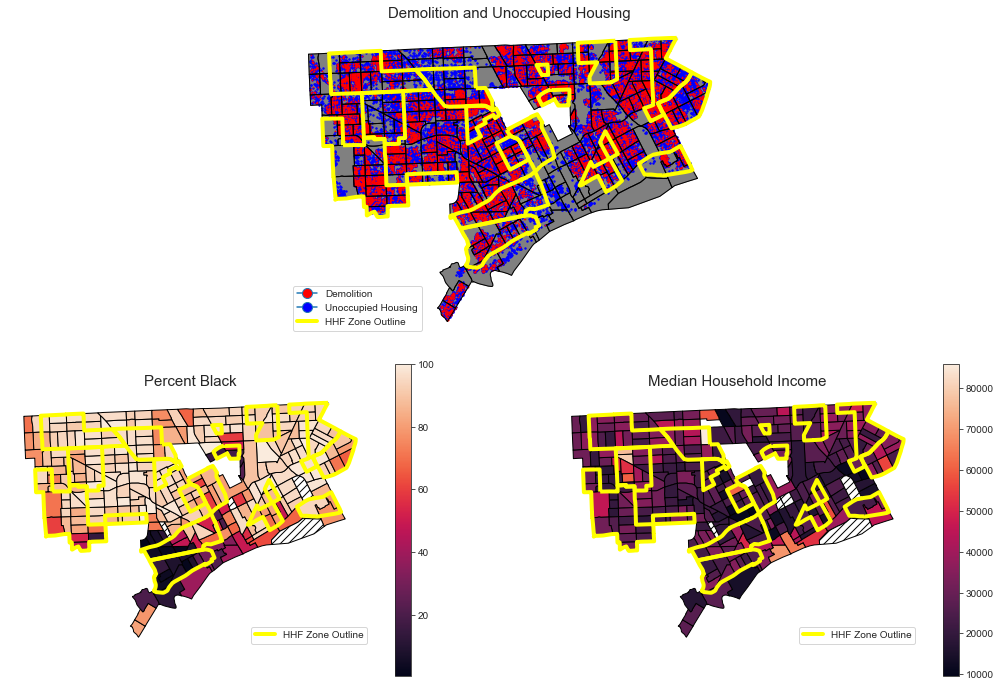

In [35]:
#overlay demolitions and tracts on same map

#create legend for main map
legend_element = [Line2D([0],[0],markerfacecolor='red', marker='o', label='Demolition', markersize=10),
                 Line2D([0],[0],markerfacecolor='blue', marker='o', label='Unoccupied Housing', markersize=10),
                 Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)]

#Create figure and grid layout
fig=plt.figure(figsize=(18,12))
spec=gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

#first plot - demolitions and unoccupied structures 
ax1 = fig.add_subplot(spec[0:2, 0:])  #take up the top row of the grid

#background
detroit_demo.plot(color='grey', edgecolor='grey', figsize=(9,6), ax=ax1)
#Unoccupied structures
trkrpoints[trkrpoints['Occupancy'] == 'unoccupied'].plot(color='blue', markersize=2, ax=ax1)
#demolitions
demos.plot(ax=ax1, markersize=.5, marker='o', color='red')
#tract outlines
detroit_demo.plot(facecolor='none', edgecolor='black', figsize=(9,6), ax=ax1)
#hardest hit fund area outlines
hhf.plot(ax=ax1, edgecolor='yellow', linewidth=4, facecolor='none')
#formatting
plt.title('Demolition and Unoccupied Housing', fontdict={'fontsize' : 15})
ax1.set_axis_off()
ax1.legend(handles=legend_element, loc='best')

ax2 = fig.add_subplot(spec[-2:, 0]) #bottom left of grid

#pct black by tract
detroit_demo.plot(column='pct_black',
                  edgecolor='black', 
                  figsize=(9,6),
                  legend=True, 
                  ax=ax2,
                  missing_kwds={'hatch' : '///', 'color' : 'white'})

#HHF outlines
hhf.plot(ax=ax2, edgecolor='yellow', linewidth=4, facecolor='none')
#formatting
plt.title('Percent Black',fontdict={'fontsize' : 15})
ax2.set_axis_off()
plt.legend(handles=[Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)], loc='lower right')


ax3 = fig.add_subplot(spec[-2:, 1]) #bottom right of grid

#plot med hh income removing two high outliers that make map hard to read
mask=~detroit_demo['GEOID10'].isin(['26163538200','26163532300'])
detroit_demo[mask].plot(column='med_household_inc',
                        edgecolor='black', 
                        figsize=(9,6),
                        legend=True, 
                        ax=ax3,
                        missing_kwds={'hatch' : '///', 'color' : 'white'})
#HHF outlines
hhf.plot(ax=ax3, edgecolor='yellow', linewidth=4, facecolor='none')
#formatting
plt.title('Median Household Income',fontdict={'fontsize' : 15})
ax3.set_axis_off()
plt.legend(handles=[Line2D([0],[0],color='yellow', label='HHF Zone Outline', markersize=10,linewidth=4)], loc='lower right')

#save
plt.gcf().savefig('figures/Demo_Demos.png', bbox_inches='tight')

## VII. Regression Analysis

Regression correlates of demolition patterns in Detroit

In [36]:
#Add HHF as a dummy variable to the data table
demo_blight_nhgis_hhf=pd.merge(demo_blight_nhgis, hhf_tract_data, how='left', left_on='GEOID10',right_on='GEOID10')
demo_blight_nhgis_hhf['hhf_dummy']=demo_blight_nhgis_hhf['Name'].notnull().astype(int)

In [37]:
#Create reg data by dropping NA's
cols=['GEOID10','demolitions','ResStruct_Unoccupied','med_household_inc','pct_black','median_house_value','hhf_dummy']
demo_blight_nhgis_hhf_regdat=demo_blight_nhgis_hhf[cols].dropna()

In [38]:
#Regression with just demographics and hhf areas

#independents
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
#dependent
ys=demo_blight_nhgis_hhf_regdat['demolitions']
#add constant
xs=sm.add_constant(xs)

#model with robust se's
models=sm.OLS(ys,xs).fit(cov_type='HC1')
print(models.summary())


                            OLS Regression Results                            
Dep. Variable:            demolitions   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     65.97
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           6.63e-39
Time:                        13:55:32   Log-Likelihood:                -1377.6
No. Observations:                 276   AIC:                             2765.
Df Residuals:                     271   BIC:                             2783.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.4755 

In [39]:
# with interaction terms between demographics and hhf areas

#independents
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
#add interaction terms
xs['hhf_pctblk'] = xs['pct_black']*xs['hhf_dummy']
xs['hhf_medinc'] = xs['med_household_inc']*xs['hhf_dummy']
#Dependent
ys=demo_blight_nhgis_hhf_regdat['demolitions']
#add constant
xs=sm.add_constant(xs)
#model
models=sm.OLS(ys,xs).fit(cov_type='HC1')
print(models.summary())

                            OLS Regression Results                            
Dep. Variable:            demolitions   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     48.29
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           5.08e-40
Time:                        13:55:32   Log-Likelihood:                -1373.5
No. Observations:                 276   AIC:                             2761.
Df Residuals:                     269   BIC:                             2786.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   22.9696 

In [40]:
#standardized regression
#Independents and calculate z scores
xs=demo_blight_nhgis_hhf_regdat[['ResStruct_Unoccupied','med_household_inc','pct_black','hhf_dummy']]
xs_standard=xs.apply(sci.zscore)

#dependent and calculate z score
ys=demo_blight_nhgis_hhf_regdat['demolitions']
ys_standard=pd.DataFrame(ys).apply(sci.zscore)
#model
models_standard=sm.OLS(ys_standard,xs_standard).fit(cov_type='HC1')
print(models_standard.summary())

                                 OLS Regression Results                                
Dep. Variable:            demolitions   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              66.21
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    4.73e-39
Time:                        13:55:32   Log-Likelihood:                         -232.27
No. Observations:                 276   AIC:                                      472.5
Df Residuals:                     272   BIC:                                      487.0
Df Model:                           4                                                  
Covariance Type:                  HC1                                                  
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [41]:
#Regression with just demographics and hhf areas

#independents
xs=demo_blight_nhgis_hhf_regdat[['med_household_inc','pct_black','hhf_dummy']]
#dependent
ys=demo_blight_nhgis_hhf_regdat['demolitions']
#add constant
xs=sm.add_constant(xs)

#model with robust se's
models=sm.OLS(ys,xs).fit(cov_type='HC1')
print(models.summary())


                            OLS Regression Results                            
Dep. Variable:            demolitions   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     12.87
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           6.92e-08
Time:                        13:55:32   Log-Likelihood:                -1526.6
No. Observations:                 276   AIC:                             3061.
Df Residuals:                     272   BIC:                             3076.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                82.8417     13.47